# Ecommerce Customer Churn
### by Farhan Guido Haryadi

## Business Problem

**Churn Prediction**  
Churn Prediction
Customer churn mengacu pada hilangnya klien atau pelanggan yang sudah ada. Dari analysis ini, kita bisa mengidentifikasi user yang cenderung akan berhenti menggunakan aplikasi ecommerce dan meninggalkan perusahaan.

Identifikasi pengguna berhenti menggunakan ecommerce ditandai dengan tidak adanya transaksi dalam kurun waktu tertentu, atau akun tersebut tidur (dormant account).

1. Salah satu dampak dari persaingan di dunia ecommerce adalah churn, sebuah kondisi dimana user berpindah dari satu ecommerce ke ecommerce yang lain.
1. Semakin tinggi churn rate, semakin kecil revenue yang akan perusahaan raih di masa mendatang.
1. Biaya untuk memperoleh user baru cukup besar, namun jauh lebih besar biaya kehilangan user karena kita kehilangan bisnis sama sekali, ditambah lagi user yang kecewa akan bercerita kepada banyak orang yang memengaruhi orang lain untuk tidak menggunakan layanan dari perusahaan kita.

**who are having problems? :**

Sebuah perusahaan E-Commerce.

**Goals :**

1. Memperluas cakupan user dan mendapatkan lebih banyak loyalitas user
1. Memuaskan user dengan karakterisitiknya masin-masing

**Analytic Approach :**

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan user yang berpotensi menjadi churn dan tidak.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas user akan tetap menggunakan E-Commerce tersebut atau tidak, agar E-Commerce dapat menentukan strategi untuk mempertahankan user.

**Metric Evaluation**

<img src='Matrix.png'>

Type 1 error : False Positive  
Konsekuensi: sia-sianya biaya perekrutan, waktu dan sumber daya

Type 2 error : False Negative  
Konsekuensi: kehilangan calon potensial 

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi cost perekrutan dari perusahaan tersebut, tetapi tanpa membuat menjadi kurangnya/tidak cukup kandidat potensial yang dibutuhkan perusahaan. Jadi harus kita seimbangkan nanti antara precision dan recallnya dari kelas positive (kandidat potensial). Jadi nanti metric utama yang akan kita gunakan adalah roc_auc.

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

C:\Users\farha\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data Understanding

In [2]:
#Load Dataset
df = pd.read_csv("data_ecommerce_customer_churn.csv")
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


Berdasarkan dataset, terdapat 3941 observasi. Kolom churn juga menunjukkan apakah pelanggan akan churn atau tidak.

Kesimpulannya, variabel target atau dependent adalah churn, dan semua kolom lainnya menjadi variabel fitur atau independent.

Note : 
- Dataset tidak seimbang
- Sebagian besar fitur bersifat kategori (Nominal, Ordinal, Binary), beberapa dengan kardinalitas tinggi
- Setiap baris data merepresentasikan informasi seorang kandidat yang ditawarkan bekerja dimasa lalu

Kita memiliki total 11 kolom dari dataset.

Deskripsi Kolom :

1.  Tenure                      : Masa pengguna berlangganan pada produk ini
1.  WarehouseToHome             : Jarak antara gudang dan rumah pengguna
1.  NumberOfDeviceRegistered    : Jumlah perangkat yang diregistrasikan terhadap satu pengguna/akun
1.  PreferredOrderCat           : Kategori yang sering dipesan dalam satu bulan terakhir
1.  SatisfactionScore           : Nilai kepuasan pelanggan terhadap pelayanan
1.  MaritalStatus               : Status pernikahan pelanggan
1.  NumberOfAddress             : Jumlah alamat yang terdaftar dalam satu pengguna
1.  Complain                    : Keluhan yang diajukan dalam satu bulan terakhir
1.  DaySinceLastOrder           : Hari terakhir pemesanan yang dilakukan oleh pelanggan 
1.  CashbackAmount              : Rata-rata cashback dalam satu bulan terakhir
1.  Churn                       : Identifikasi pengguna churn atau tidak.
                                    Jika bernilai 1 maka pengguna churn,
                                    Jika bernilai 0 maka pengguna tidak churn

In [3]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


## Business Problem & Data Understanding

## Data Cleaning, Feature selection, & Feature Engineering

In [4]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample().values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Tenure,float64,194,4.92,36,[13.0]
1,WarehouseToHome,float64,169,4.29,33,[8.0]
2,NumberOfDeviceRegistered,int64,0,0.00,6,[2]
3,PreferedOrderCat,object,0,0.00,6,[Mobile Phone]
4,SatisfactionScore,int64,0,0.00,5,[1]
5,MaritalStatus,object,0,0.00,3,[Divorced]
6,NumberOfAddress,int64,0,0.00,14,[6]
7,Complain,int64,0,0.00,2,[0]
8,DaySinceLastOrder,float64,213,5.40,22,[15.0]
9,CashbackAmount,float64,0,0.00,2335,[232.47000000000003]


In [5]:
# Mengecek value yang aneh
print ("Number of Every Distinct Categorical Feature\n")

for col_name in df.columns:
    if df[col_name].dtypes =='object':
        print ('\nNumber of unique category in {} : {}'.format(col_name, df[col_name].nunique()))
        print ('The values are :')
        print (df[col_name].value_counts())

Number of Every Distinct Categorical Feature


Number of unique category in PreferedOrderCat : 6
The values are :
Laptop & Accessory    1458
Mobile Phone           887
Fashion                585
Mobile                 559
Grocery                273
Others                 179
Name: PreferedOrderCat, dtype: int64

Number of unique category in MaritalStatus : 3
The values are :
Married     2055
Single      1310
Divorced     576
Name: MaritalStatus, dtype: int64


dapat kita lihat pada PreferedOrderCat terdapat value 'Mobile Phone' dan 'Mobile' yang mana menurut saya kedua hal ini sama saja. Jadi saya akan merubah mobile menjadi mobile phone

In [6]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample().values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Tenure,float64,194,4.92,36,[nan]
1,WarehouseToHome,float64,169,4.29,33,[127.0]
2,NumberOfDeviceRegistered,int64,0,0.00,6,[1]
3,PreferedOrderCat,object,0,0.00,6,[Mobile]
4,SatisfactionScore,int64,0,0.00,5,[3]
5,MaritalStatus,object,0,0.00,3,[Single]
6,NumberOfAddress,int64,0,0.00,14,[6]
7,Complain,int64,0,0.00,2,[0]
8,DaySinceLastOrder,float64,213,5.40,22,[5.0]
9,CashbackAmount,float64,0,0.00,2335,[147.71]


In [7]:
df['PreferedOrderCat'].replace('Mobile','Mobile Phone', inplace=True)

In [8]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample().values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Tenure,float64,194,4.92,36,[nan]
1,WarehouseToHome,float64,169,4.29,33,[30.0]
2,NumberOfDeviceRegistered,int64,0,0.00,6,[1]
3,PreferedOrderCat,object,0,0.00,5,[Mobile Phone]
4,SatisfactionScore,int64,0,0.00,5,[1]
5,MaritalStatus,object,0,0.00,3,[Married]
6,NumberOfAddress,int64,0,0.00,14,[19]
7,Complain,int64,0,0.00,2,[0]
8,DaySinceLastOrder,float64,213,5.40,22,[31.0]
9,CashbackAmount,float64,0,0.00,2335,[156.73]


In [9]:
df[df.duplicated()]

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
70,1.0,11.0,4,Mobile Phone,5,Single,3,0,1.0,154.73,1
128,1.0,10.0,4,Mobile Phone,1,Single,3,1,1.0,140.69,1
194,18.0,26.0,3,Laptop & Accessory,3,Single,9,0,1.0,148.50,0
253,19.0,6.0,3,Fashion,5,Married,2,0,7.0,204.53,0
289,16.0,36.0,4,Laptop & Accessory,3,Married,4,0,3.0,170.56,0
...,...,...,...,...,...,...,...,...,...,...,...
3930,22.0,17.0,3,Laptop & Accessory,1,Single,4,0,4.0,145.07,0
3932,20.0,15.0,5,Laptop & Accessory,5,Married,10,1,8.0,171.15,0
3934,10.0,25.0,3,Laptop & Accessory,3,Married,4,0,2.0,157.68,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0


In [10]:
# Find duplicate columns in a DataFrame.
def getDuplicateColumns(df):
  
    # Create an empty set
    duplicateColumnNames = set()
      
    # Iterate through all the columns 
    # of dataframe
    for x in range(df.shape[1]):
          
        # Take column at xth index.
        col = df.iloc[:, x]
          
        # Iterate through all the columns in
        # DataFrame from (x + 1)th index to
        # last index
        for y in range(x + 1, df.shape[1]):
              
            # Take column at yth index.
            otherCol = df.iloc[:, y]
              
            # Check if two columns at x & y
            # index are equal or not,
            # if equal then adding 
            # to the set
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
                  
    # Return list of unique column names 
    # whose contents are duplicates.
    return list(duplicateColumnNames)

In [11]:
# Get list of duplicate columns
duplicateColNames = getDuplicateColumns(df)
  
print('Duplicate Columns are :')
        
# Iterate through duplicate
# column names
for column in duplicateColNames :
    print('Column Name : ', column)

Duplicate Columns are :


Dari hasil diatas, dapat dilihat bahwa tidak ada duplikat data pada baris dataframe

### Data Cleaning

Ada data yang hilang/kosong dibeberapa fitur/kolom, maka kita akan memperbaiki semua datanya dan membuatnya menjadi siap pakai untuk melakukan analisa terhadap masalahnya dan juga pembuatan model machine learningnya.

#### Bar Plot

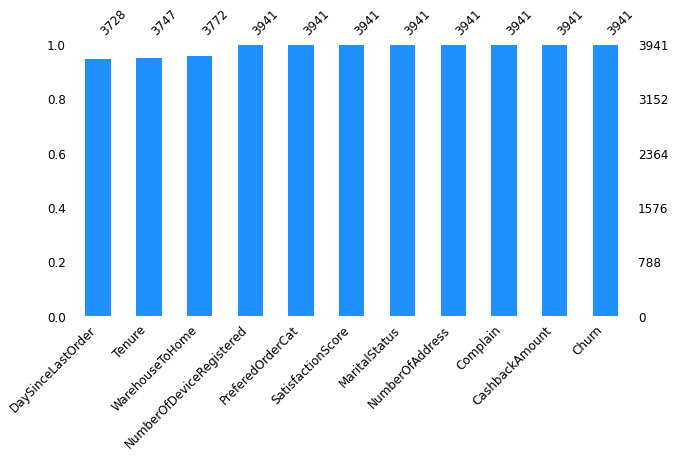

In [12]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

Terlihat dari Bar Plot tersebut, bahwa kolom DaySinceLastOrder, Tenure, dan WarehouseToHome memiliki missing values/data yang hilang. (informasi ini sebenarnya dapat dilihat juga ditable atas)

#### Matrix Plot

<AxesSubplot:>

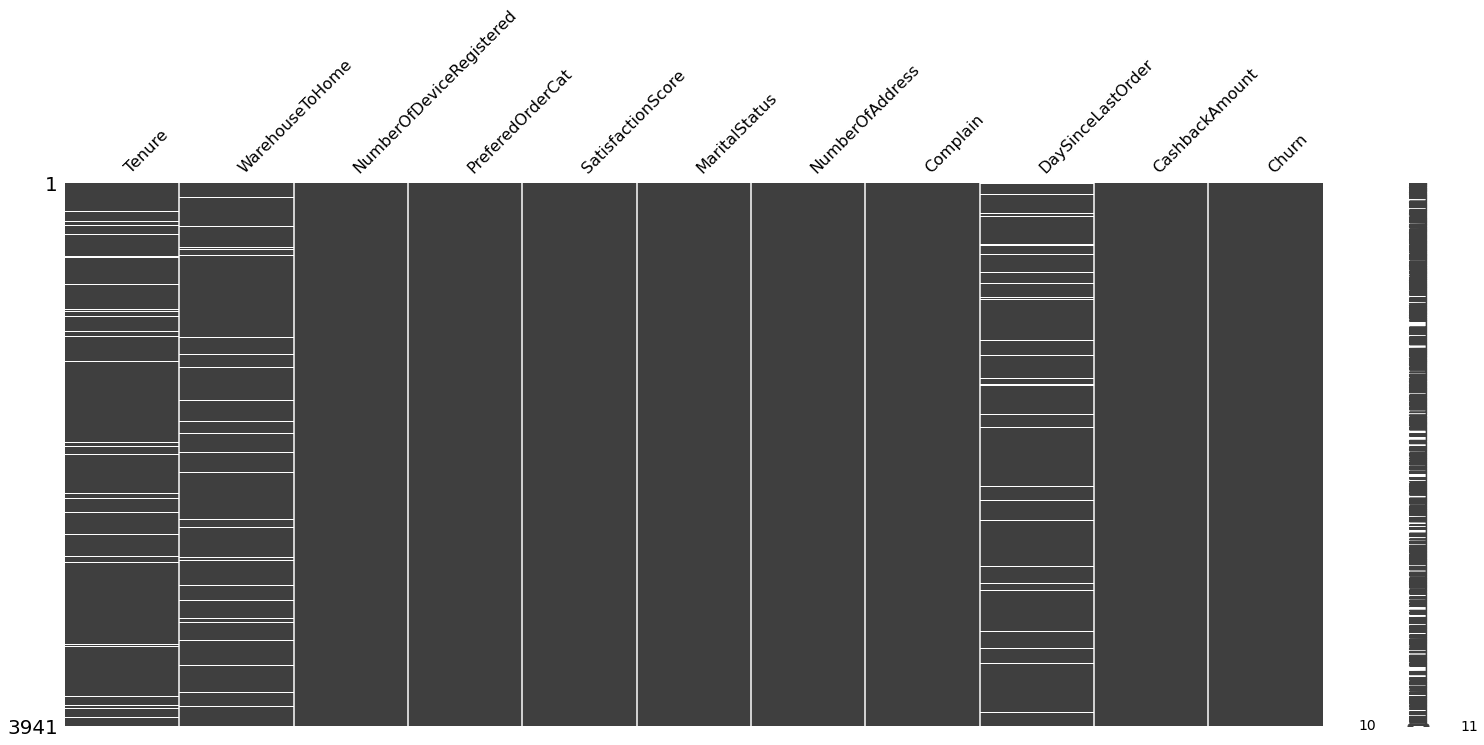

In [13]:
missingno.matrix(df)

Dapat dilihat dari sini jika kolom Tenure, WarehouseToHome, dan DaySinceLastOrder yang kosong berada di baris yang berbeda-beda. Total terdapat 576 baris yang memiliki beberapa kolom kosong.

#### Heatmap

Di bawah ini kita memplot Heatmap yang menunjukkan korelasi nulitas antara berbagai kolom yang memiliki data yang hilang pada dataset kita.

Korelasi nulitas berkisar dari -1 hingga 1.

- -1 - Korelasi Negatif yang menyatakan bahwa jika nilai satu variabel ada maka nilai variabel lain pasti tidak ada.
- 0 - Tidak ada korelasi yang menyatakan bahwa nilai variabel yang ada atau tidak ada tidak berpengaruh satu sama lain.
- 1 - Korelasi Positif yang menyatakan bahwa jika nilai satu variabel ada maka nilai yang lain pasti ada

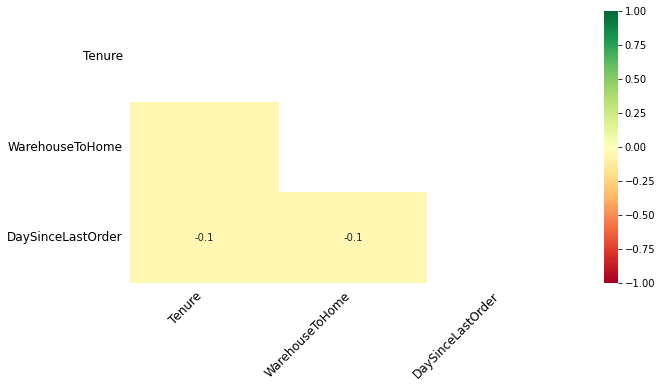

In [14]:
missingno.heatmap(df, cmap="RdYlGn", figsize=(10,5), fontsize=12);

Terlihat dari Heatmap tersebut, bahwa rata-rata missing values/data yang hilang antara 1 kolom dengan kolom yang lainnya itu tidak berhubungan/berkorelasi.

Missing Value Tenure

In [15]:
# menghitung value count dari tiap value di Tenure
df['Tenure'].value_counts()

1.0     489
0.0     347
8.0     192
9.0     166
10.0    155
4.0     151
7.0     151
5.0     145
11.0    136
3.0     136
6.0     134
14.0    128
12.0    127
13.0    122
2.0     117
19.0    111
15.0    103
16.0    102
20.0     80
18.0     79
17.0     79
23.0     59
21.0     54
24.0     51
22.0     50
30.0     46
28.0     44
27.0     43
26.0     41
25.0     40
29.0     33
31.0     32
61.0      1
51.0      1
60.0      1
50.0      1
Name: Tenure, dtype: int64

In [16]:
df['Tenure'].mean()

10.081398452095009

In [17]:
# mengisi missing value dengan nilai rata-rata (dibulatkan)

for i in list(['Tenure']):
    df[i].fillna(10, inplace=True)

Missing Value WarehouseToHome

In [18]:
df['WarehouseToHome'].value_counts()

9.0      380
8.0      310
7.0      277
14.0     215
16.0     211
15.0     210
6.0      205
10.0     190
13.0     173
11.0     169
12.0     157
17.0     143
31.0      77
22.0      76
23.0      70
21.0      67
30.0      66
25.0      65
18.0      65
35.0      64
26.0      62
32.0      61
24.0      58
19.0      57
27.0      55
20.0      52
33.0      52
28.0      51
29.0      48
34.0      43
36.0      36
5.0        6
127.0      1
Name: WarehouseToHome, dtype: int64

In [19]:
df['WarehouseToHome'].mean()

15.650583244962885

In [20]:
# mengisi missing value dengan nilai rata-rata (dibulatkan)

for i in list(['WarehouseToHome']):
    df[i].fillna(16, inplace=True)

Missing Value DaySinceLastOrder

In [21]:
# menghitung value count dari tiap value di Tenure
df['DaySinceLastOrder'].value_counts()

3.0     632
2.0     546
1.0     438
8.0     382
0.0     345
7.0     314
4.0     312
9.0     208
5.0     155
10.0    111
6.0      81
11.0     58
12.0     42
13.0     33
14.0     28
15.0     13
17.0     12
16.0      8
18.0      7
30.0      1
46.0      1
31.0      1
Name: DaySinceLastOrder, dtype: int64

In [22]:
df['DaySinceLastOrder'].mean()

4.531652360515022

In [23]:
# mengisi missing value dengan nilai rata-rata (dibulatkan)

for i in list(['DaySinceLastOrder']):
    df[i].fillna(5, inplace=True)

##### Numerical Features Distribution

In [24]:
df.describe()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000
mean,10.077392,15.665567,3.679269,3.088302,4.237757,0.282416,4.556965,176.707419,0.171023
std,8.287006,8.269343,1.013938,1.381832,2.626699,0.450232,3.568704,48.791784,0.376576
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.700000,0.000000
50%,9.000000,14.000000,4.000000,3.000000,3.000000,0.000000,4.000000,163.340000,0.000000
75%,15.000000,20.000000,4.000000,4.000000,6.000000,1.000000,7.000000,195.250000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


In [25]:
df.dropna().describe()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000
mean,10.077392,15.665567,3.679269,3.088302,4.237757,0.282416,4.556965,176.707419,0.171023
std,8.287006,8.269343,1.013938,1.381832,2.626699,0.450232,3.568704,48.791784,0.376576
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.700000,0.000000
50%,9.000000,14.000000,4.000000,3.000000,3.000000,0.000000,4.000000,163.340000,0.000000
75%,15.000000,20.000000,4.000000,4.000000,6.000000,1.000000,7.000000,195.250000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


Seperti yang kita lihat distribusi data dari kolom/fitur numerik yang kita punya cukup hampir sama setelah data yang kosong/hilang dihapus, dimana dapat dilihat dari mean dan stdnya.

Mari kita check perubahan distribusi data dari kolom target kita dengan lebih detail.

In [26]:
df['Churn'].value_counts()

0    3267
1     674
Name: Churn, dtype: int64

In [27]:
df.dropna()['Churn'].value_counts()

0    3267
1     674
Name: Churn, dtype: int64

In [28]:
df['Churn'].value_counts()/len(df['Churn']) * 100

0    82.897742
1    17.102258
Name: Churn, dtype: float64

In [29]:
df.dropna()['Churn'].value_counts()/len(df.dropna()['Churn']) * 100

0    82.897742
1    17.102258
Name: Churn, dtype: float64

Terlihat bahwa distribusi kolom Churn sangat sedikit berbeda seperti sebelum data kosong dihapus

##### Categorical Features Distribution

In [30]:
df.describe(include=['O'])

,PreferedOrderCat,MaritalStatus
count,3941,3941
unique,5,3
top,Laptop & Accessory,Married
freq,1458,2055


In [31]:
df.dropna().describe(include=['O'])

,PreferedOrderCat,MaritalStatus
count,3941,3941
unique,5,3
top,Laptop & Accessory,Married
freq,1458,2055


Terlihat bahwa untuk kolom categorical, ada 1 data kota/city yang menghilang, dan 2 data education_level yang menghilang. Mari kita check lebih lanjut ke 2 kolom tersebut.

Terlihat bahwa untuk kolom categorical, tidak ada value yang hilang. PreferedOrderCat tetap 6 dan MaritalStatus tetap memiliki 3 unique values

In [32]:
for i in df.loc[:,["PreferedOrderCat","MaritalStatus"]].columns:
    relevent_experience_df = df.groupby(i)['Churn'].value_counts(normalize=True).unstack()
    display(relevent_experience_df.sort_values(by=[1.0], ascending=False))

Churn,0,1
PreferedOrderCat,,
Mobile Phone,0.713693,0.286307
Fashion,0.839316,0.160684
Laptop & Accessory,0.902606,0.097394
Others,0.932961,0.067039
Grocery,0.956044,0.043956


Churn,0,1
MaritalStatus,,
Single,0.729008,0.270992
Divorced,0.845486,0.154514
Married,0.888078,0.111922


Berdasarkan table diatas kita dapat menyimpulkan beberapa hal:

1. Pengguna yang PreferedOrderCatnya Mobile Phone cenderung churn daripada yang lain.
1. Pengguna yang single cenderung lebih berpeluang untuk Churn

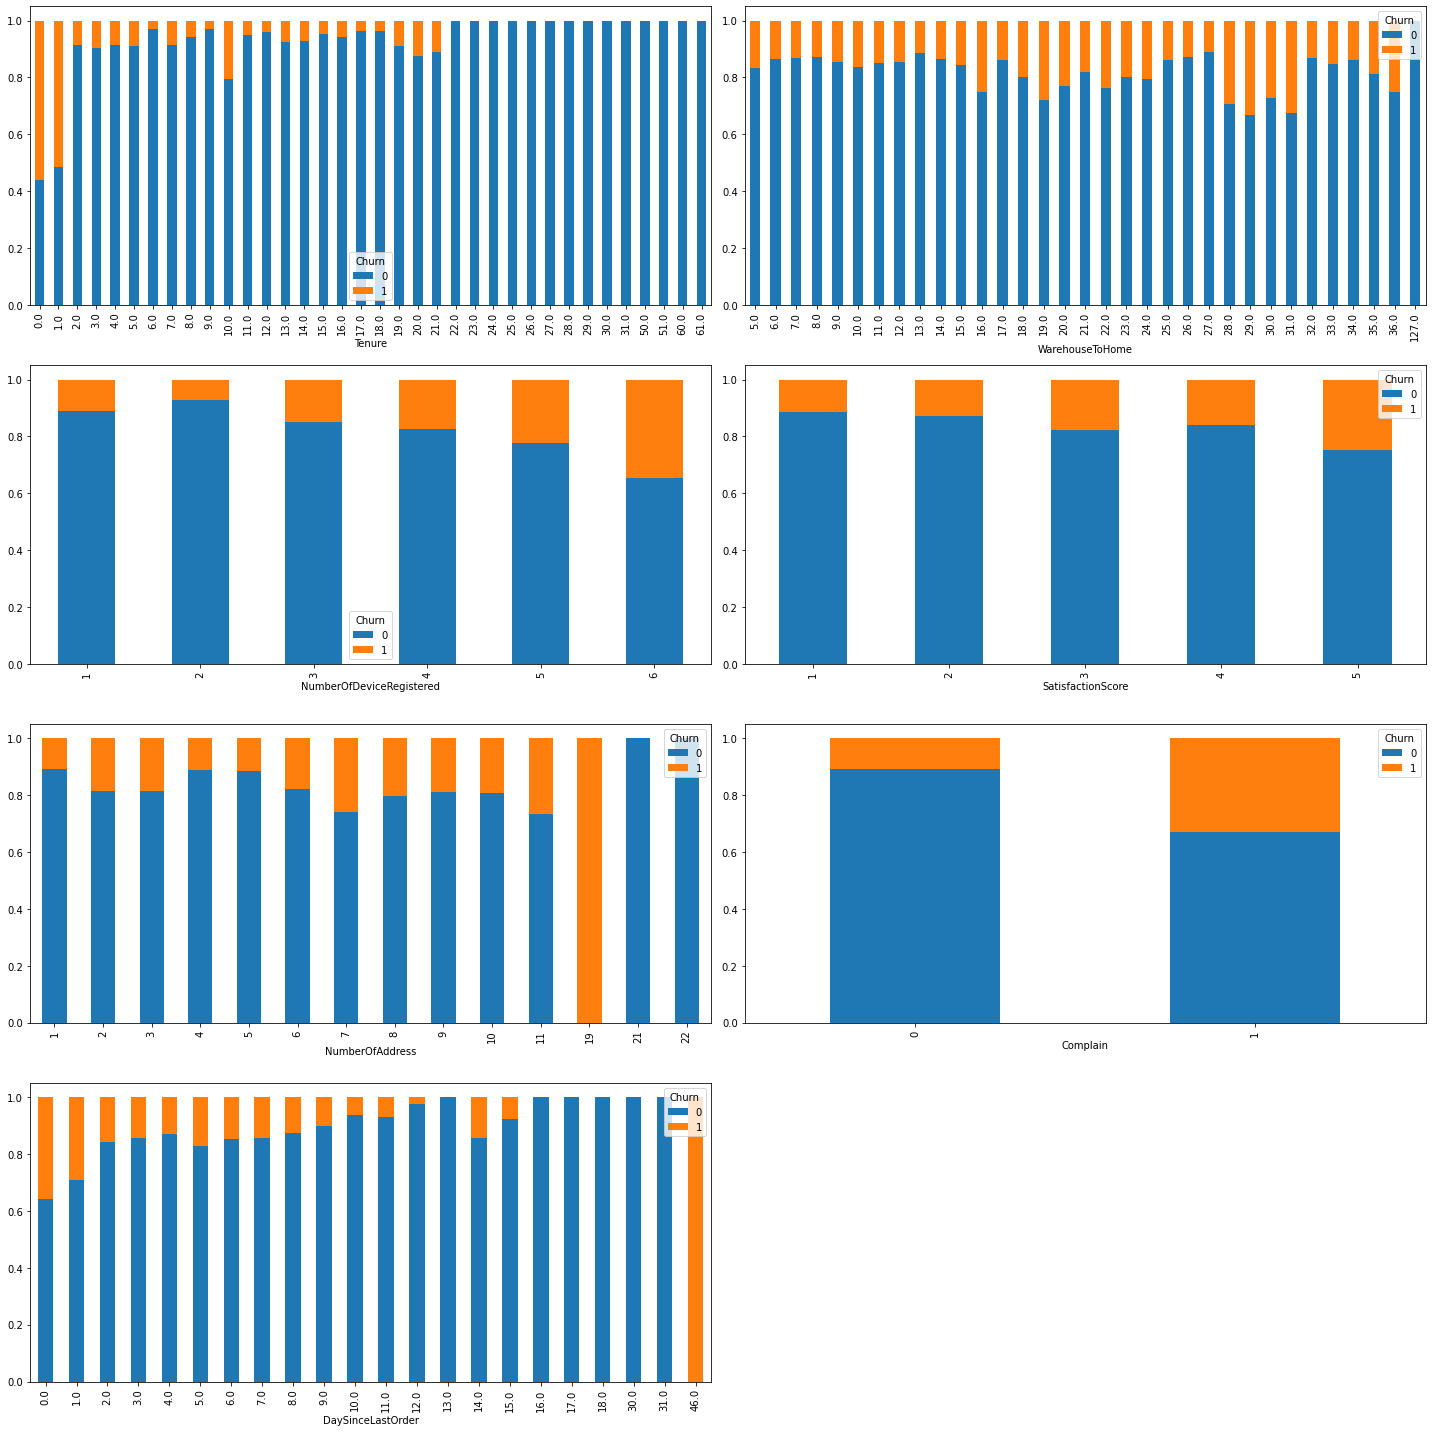

In [33]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['Churn','PreferedOrderCat','MaritalStatus','CashbackAmount']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['Churn'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

## Data Preparation 

In [34]:
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile Phone,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,5.0,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,16.0,4,Mobile Phone,3,Married,10,1,0.0,124.37,1


Merubah Fitur/Kolom PreferedOrderCat dan MaritalStatus menggunakan OneHotEncoder, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit

In [35]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['PreferedOrderCat','MaritalStatus']),
], remainder='passthrough')

In [36]:
x = df.drop(columns=['Churn'])
y = df['Churn']

In [37]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=2021)

In [38]:
testing = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names())
testing.head()

,onehot__x0_Grocery,onehot__x0_Laptop & Accessory,onehot__x0_Mobile Phone,onehot__x0_Others,onehot__x1_Married,onehot__x1_Single,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount
0,0.0,1.0,0.0,0.0,1.0,0.0,18.0,15.0,4.0,3.0,2.0,0.0,12.0,155.93
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6.0,4.0,4.0,2.0,0.0,0.0,128.36
2,0.0,0.0,1.0,0.0,0.0,1.0,10.0,28.0,3.0,3.0,2.0,1.0,0.0,116.75
3,0.0,1.0,0.0,0.0,1.0,0.0,13.0,8.0,3.0,4.0,8.0,0.0,3.0,157.15
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,9.0,6.0,1.0,7.0,1.0,3.0,159.64


## Modeling & Evaluation

### Model Benchmarking : K-Fold

In [39]:
logreg = LogisticRegression()

In [40]:
models = logreg
score=[]
rata=[]
std=[]


skfold=StratifiedKFold(n_splits=5)
estimator=Pipeline([
    ('preprocess',transformer),
    ('model',logreg)])
model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
score.append(model_cv)
rata.append(model_cv.mean())
std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
Logistic Regression,0.872138,0.018476


### Model Benchmarking : Test Data

In [41]:
models = [logreg,logreg]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'Logistic Regression']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'Logistic Regression'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       654
           1       0.74      0.40      0.52       135

    accuracy                           0.87       789
   macro avg       0.81      0.69      0.72       789
weighted avg       0.86      0.87      0.86       789

Logistic Regression 
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       654
           1       0.74      0.40      0.52       135

    accuracy                           0.87       789
   macro avg       0.81      0.69      0.72       789
weighted avg       0.86      0.87      0.86       789



,roc_auc score
model,
Logistic Regression,0.88557
Logistic Regression,0.88557


### Test Oversampling with K-Fold Cross Validation

In [42]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [43]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [44]:
data = x_train
target = y_train

In [45]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    logreg = LogisticRegression()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',logreg)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

#### Evaluation Metrics Without Oversampling

In [46]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.879760,0.873418,0.873052,0.860687,0.753167,0.719734,0.478351,0.388889,0.725000,0.750000
1,0.881171,0.886076,0.874778,0.894049,0.752980,0.762366,0.470103,0.481481,0.740260,0.764706
2,0.881213,0.860317,0.880232,0.838398,0.753515,0.703745,0.471193,0.396226,0.741100,0.636364
3,0.882270,0.879365,0.875529,0.874131,0.757997,0.770408,0.484536,0.555556,0.736677,0.681818
4,0.884737,0.850794,0.882569,0.825103,0.761831,0.713642,0.486598,0.462963,0.751592,0.581395
5,0.880155,0.879365,0.874179,0.882929,0.752621,0.739011,0.474227,0.425926,0.730159,0.766667
6,0.883680,0.879365,0.879478,0.845537,0.767142,0.749036,0.515464,0.462963,0.724638,0.735294
7,0.883327,0.882540,0.876359,0.860934,0.762872,0.757939,0.498969,0.481481,0.733333,0.742857
8,0.879803,0.917460,0.875089,0.925287,0.747388,0.834532,0.455670,0.611111,0.741611,0.868421
9,0.882270,0.860317,0.876359,0.902866,0.756987,0.709410,0.480412,0.407407,0.739683,0.647059


#### Evaluation Metrics With Oversampling

In [47]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.786261,0.762658,0.872581,0.864292,0.786236,0.697113,0.797108,0.870370,0.780183,0.408696
1,0.785198,0.806962,0.870620,0.892211,0.785172,0.739285,0.796257,0.870370,0.779026,0.465347
2,0.801148,0.774603,0.876804,0.839479,0.801095,0.696231,0.817524,0.792453,0.791598,0.411765
3,0.793793,0.806349,0.877308,0.881368,0.793736,0.736712,0.810374,0.851852,0.784362,0.464646
4,0.800170,0.739683,0.878843,0.821413,0.800083,0.659307,0.821003,0.740741,0.788163,0.370370
5,0.800170,0.825397,0.877561,0.882716,0.800140,0.751224,0.812500,0.814815,0.792946,0.494382
6,0.804634,0.774603,0.881669,0.853200,0.804469,0.690788,0.833759,0.740741,0.787867,0.412371
7,0.796131,0.758730,0.875417,0.865971,0.796033,0.673415,0.818027,0.722222,0.783707,0.390000
8,0.792730,0.790476,0.873642,0.922236,0.792671,0.725783,0.809524,0.888889,0.783217,0.444444
9,0.801446,0.793651,0.876121,0.895700,0.801391,0.716919,0.818027,0.796296,0.791770,0.443299


Terlihat bahwa hasil evaluation metricsnya untuk recall dari class positive lebih baik setelah di oversampling dari yang tidak di oversampling tetapi precisionnya tebakan class positive menjadi lebih buruk. 

Ini masuk akal karena class positive datanya kita perbanyak menjadi sama dengan jumlah data dari class negative, dimana ini biasa memang akan membuat recall dari class yg minoritas naik tetapi otomatis biasa precisionnya juga akan turun sebagai dampaknya. Tetapi untuk kasus kali ini recallnya naik lebih tinggi dari pada precisionnya yang turun. Dan dampak ini terhadap kasus permasalahan kita berarti model kita setelah di oversampling, menjadi mendapatkan user berpotensi churn yang lebih banyak dari sebelumnya, tetapi berkurang dalam ketepatan/precision tebakannya untuk user berpotensi churn, yang menyebabkan cost biaya recruitment yang terbuang menjadi lebih tinggi dari model yang tidak di oversampling.

Sekarang pertanyaannya, model manakah yang lebih baik dan harus kita gunakan? menentukan ini kembali lagi tergantung permasalahan yang sedang dihadapi dan berdasarkan pengertian/pengalaman terhadap domain permasalahannya. 

Dimana intinya, pemilihan model yang digunakan harus berdasarkan permasalahan yang dihadapi dan yang dapat menyelesaikan masalahnya paling baik (berdampak paling baik terhadap bisnis/organisasi yang bersangkutan (stakeholdernya)).

Mari sekarang kita lihat juga classification reportsnya.

#### Classification Reports Without Oversampling

In [48]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       262
           1       0.75      0.39      0.51        54

    accuracy                           0.87       316
   macro avg       0.82      0.68      0.72       316
weighted avg       0.86      0.87      0.86       316

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       262
           1       0.76      0.48      0.59        54

    accuracy                           0.89       316
   macro avg       0.83      0.73      0.76       316
weighted avg       0.88      0.89      0.88       316

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       262
           1       0.64      0.40      0.49        53

    accuracy                           0.86       315
   macro avg       0.76      0.68      0.70       315
weighted avg       0.84      0.86      0.85       315

              preci

#### Classification Reports With Oversampling

In [49]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.97      0.74      0.84       262
           1       0.41      0.87      0.56        54

    accuracy                           0.76       316
   macro avg       0.69      0.81      0.70       316
weighted avg       0.87      0.76      0.79       316

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       262
           1       0.47      0.87      0.61        54

    accuracy                           0.81       316
   macro avg       0.72      0.83      0.74       316
weighted avg       0.88      0.81      0.83       316

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       262
           1       0.41      0.79      0.54        53

    accuracy                           0.77       315
   macro avg       0.68      0.78      0.70       315
weighted avg       0.86      0.77      0.80       315

              preci

Terlihat bahwa model yang setelah di oversampling memiliki recall dari kedua class yang lebih seimbang. Oleh karena itu untuk kasus kali ini, mari kita gunakan model yang menggunakan oversampling.

Sekarang mari kita coba melakukan hyperparameter tuning pada model Logistic Regression kita untuk mendapatkan hasil yang lebih baik lagi.

Hyperparameter Tuning

Splitting the Data

In [50]:
df_encoded = pd.DataFrame(transformer.fit_transform(df))
df_encoded.columns = transformer.get_feature_names()
df_encoded

,onehot__x0_Grocery,onehot__x0_Laptop & Accessory,onehot__x0_Mobile Phone,onehot__x0_Others,onehot__x1_Married,onehot__x1_Single,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,0.0,1.0,0.0,0.0,0.0,1.0,15.0,29.0,4.0,3.0,2.0,0.0,7.0,143.32,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,7.0,25.0,4.0,1.0,2.0,0.0,7.0,129.29,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,27.0,13.0,3.0,1.0,5.0,0.0,7.0,168.54,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,20.0,25.0,4.0,3.0,7.0,0.0,5.0,230.27,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,30.0,15.0,4.0,4.0,8.0,0.0,8.0,322.17,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.0,0.0,0.0,0.0,1.0,0.0,28.0,9.0,5.0,3.0,8.0,0.0,1.0,231.86,0.0
3937,0.0,0.0,1.0,0.0,0.0,1.0,8.0,7.0,2.0,2.0,4.0,0.0,4.0,157.80,0.0
3938,0.0,1.0,0.0,0.0,1.0,0.0,30.0,6.0,5.0,3.0,3.0,1.0,2.0,156.60,0.0
3939,0.0,0.0,1.0,0.0,1.0,0.0,6.0,16.0,4.0,3.0,10.0,1.0,0.0,124.37,1.0


In [51]:
#Training Dataset & Testing Dataset

X = df_encoded.drop(columns=["Churn"])
Y = df_encoded["Churn"]

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    stratify=Y,
    test_size=0.2, 
    random_state=2022
)

Penalized Logistic Regression

In [53]:
model = LogisticRegression(class_weight = 'balanced')
skf = StratifiedKFold(n_splits = 5)
model_cv = cross_val_score(model, X_train, Y_train, cv = skf, scoring = 'f1')

In [54]:
print(model_cv)
print(model_cv.mean())
print(model_cv.std())

[0.53134328 0.63087248 0.56949153 0.55238095 0.55696203]
0.5682100539849405
0.033658459778561696


Logistic Regression with SMOTE

In [55]:
smote = SMOTE()
model = LogisticRegression()

pipe_model = Pipeline ([
            ('balance', smote),
            ('clf', model)
])

#metode cross validation
skf = StratifiedKFold(n_splits=5)

In [56]:
model_smote_cv = cross_val_score(pipe_model, X_train, Y_train, cv = skf, scoring='f1')

In [57]:
print(model_smote_cv)
print(model_smote_cv.mean())
print(model_smote_cv.std())

[0.56074766 0.62666667 0.55290102 0.55844156 0.57142857]
0.5740370967957966
0.026993478692995263


Final Model Performance

In [58]:
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced')

In [59]:
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.79      0.86       654
         1.0       0.44      0.82      0.58       135

    accuracy                           0.79       789
   macro avg       0.70      0.80      0.72       789
weighted avg       0.87      0.79      0.81       789



Tuning

In [60]:
#model
smote = SMOTE()
model = LogisticRegression()
pipe_model = Pipeline ([
            ('balance', smote),
            ('clf', model)
])

#metode cross validation
skf = StratifiedKFold(n_splits=5)

#hyperparameter
prams = {
    'balance__k_neighbors':[2,5,10,15,20],
    'clf__C':[100,10,1,0.1,0.01,0.001],
    'clf__solver':['lbfgs','liblinear','newton-cg']
}

grid_search = GridSearchCV(
    pipe_model,
    param_grid = prams, 
    cv = skf,
    scoring = 'f1',
    n_jobs = -1
)
#default C=1.0, solver=lbfgs, balance__k_neighbors = 5

In [61]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('balance', SMOTE()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'balance__k_neighbors': [2, 5, 10, 15, 20],
                         'clf__C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'clf__solver': ['lbfgs', 'liblinear', 'newton-cg']},
             scoring='f1')

In [62]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.5839203566636367
{'balance__k_neighbors': 15, 'clf__C': 100, 'clf__solver': 'newton-cg'}


In [63]:
hasil_tuning = pd.DataFrame(grid_search.cv_results_)

In [64]:
hasil_tuning[hasil_tuning['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_balance__k_neighbors,param_clf__C,param_clf__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
56,0.318556,0.012257,0.007643,0.001602,15,100,newton-cg,"{'balance__k_neighbors': 15, 'clf__C': 100, 'c...",0.575163,0.62,0.588235,0.569536,0.566667,0.58392,0.019502,1


In [65]:
hasil_tuning[(hasil_tuning['param_balance__k_neighbors'] == 5)&(hasil_tuning['param_clf__C']==1.0)&(hasil_tuning['param_clf__solver']=='lbfgs')]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_balance__k_neighbors,param_clf__C,param_clf__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,0.214242,0.025369,0.017914,0.007174,5,1,lbfgs,"{'balance__k_neighbors': 5, 'clf__C': 1, 'clf_...",0.54878,0.618557,0.553633,0.557692,0.56051,0.567834,0.025667,50


Comparation

In [66]:
smote = SMOTE()
model = LogisticRegression()
pipe_model = Pipeline ([
            ('balance', smote),
            ('clf', model)
])


In [67]:
# before
pipe_model.fit(X_train, Y_train)
Y_pred = pipe_model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.79      0.86       654
         1.0       0.44      0.79      0.57       135

    accuracy                           0.79       789
   macro avg       0.70      0.79      0.72       789
weighted avg       0.86      0.79      0.81       789



In [68]:
pipe_model = grid_search.best_estimator_

In [69]:
pipe_model.fit(X_train, Y_train)
Y_pred = pipe_model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.81      0.87       654
         1.0       0.46      0.80      0.58       135

    accuracy                           0.80       789
   macro avg       0.71      0.80      0.73       789
weighted avg       0.87      0.80      0.82       789



PICKLE

In [70]:
import pickle
pickle.dump(pipe_model, open('LogisticRegressionModel.pkl', 'wb'))

Disini kita dapat melihat peningkatan performa setelah menggunakan balanced Logistic Regression dan Hypertuning with recall dengan skor terbaik.

Rekomendasi yang bisa saya berikan ialah dengan melakukan feature engineering yang lebih dalam serta mencoba algoritma klasifikasi yang lain untuk melihat mana kah yang terbaik.